In [61]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase, JLD

In [78]:
type = "MUN" 

rng = Random.default_rng()
# graph parameters
n = 200
p = 0.9
q = 0
# planted ranking score
planted_score = randperm(rng,n)

eta_vect = 0.02:0.005:0.08
n_iter = size(eta_vect,1)
m_emp = zeros(size(eta_vect))
std_emp = zeros(size(eta_vect))
m_theo = zeros(size(eta_vect))
std_theo = zeros(size(eta_vect))

n_rep = 500


for iter in 1:n_iter
    eta = eta_vect[iter]
    # graph model
    if type=="MUN"
        meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
    elseif type=="ERO"
        meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
    end

    vec_steps = zeros(n_rep,1)
    for n = 1:n_rep
        mtsf = multi_type_spanning_forest(rng, meta_g, q)
        nb_steps = get_prop(mtsf, :nb_steps)
        vec_steps[n] = nb_steps
    end
    m_emp[iter] = mean(vec_steps)
    std_emp[iter] = std(vec_steps)

    B = magnetic_incidence(meta_g)
    L = B'*B
    D = diagm(diag(L))
    W = D - L
    P = inv(D) * W

    s = real(eigvals(P))
    m_theo[iter] = sum(1 ./(1 .- s))

    std_theo[iter] = sqrt(sum(s ./ (1 .- s).^2))
end


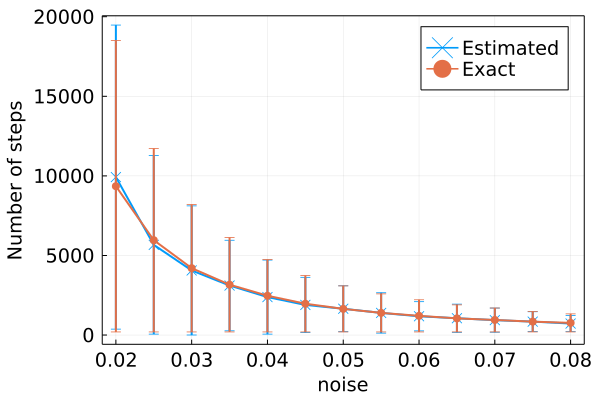

In [80]:
x = eta_vect
y = m_emp
y_er = std_emp
method = "Estimated"

y_tick = [0,0.5,1,1.5,2] * 10^4

plt = Plots.plot(
        x,
        y;
        yerror=y_er,
        labels=method,
        markerstrokecolor=:auto,
        markershape=:xcross,
        markersize=5,
        linewidth=2,
        markerstrokewidth=2,
        ytick = y_tick,
        xtickfont=font(13),
        ytickfont=font(13),
        guidefont=font(13),
        legendfont=font(13),
        framestyle=:box,
        margins=0.1 * 2cm,
        xlabel = "eta",
        )
    xlabel!("noise")
    ylabel!("Number of steps")

    method = "Exact"
    y = m_theo
    y_er = std_theo
    Plots.plot!(
        x,
        y;
        yerror=y_er,
        labels=method,
        markerstrokecolor=:auto,
        markershape=:circle,
        markersize=5,
        linewidth=2,
        markerstrokewidth=2,
        ytick = y_tick,
        xtickfont=font(13),
        ytickfont=font(13),
        guidefont=font(13),
        legendfont=font(13),
        framestyle=:box,
        margins=0.1 * 2cm,
        formatter = :plain
    )
name = "number_of_steps"
savefig(name*".pdf")



In [82]:
name = "number_of_steps"
savefig("figures/"*name*".pdf")